### Using road station data from the glatmodel to improve the forecast of road surface temperature

We will use some extra information from the forecast of wind speed, wind direction, cloud cover and air temperature
to correct the prediction of TROAD
Note we are using forecast data for the features, not observational data, since the variables
above are not so widely available in all stations



In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pytz


In [89]:
DATADIR="/media/cap/extra_work/data/road_model"

# Read the data from the CSV files
road_temp_df = pd.read_csv(os.path.join(DATADIR,'FYN_TROAD_glatmodel_data.csv.gz'))
wind_speed_df = pd.read_csv(os.path.join(DATADIR,'FYN_S10m_glatmodel_fcst.csv.gz'))
wind_dir_df = pd.read_csv(os.path.join(DATADIR,'FYN_D10m_glatmodel_fcst.csv.gz'))
cloud_cover_df = pd.read_csv(os.path.join(DATADIR,'FYN_CCtot_glatmodel_fcst.csv.gz'))
t2m_df = pd.read_csv(os.path.join(DATADIR,'FYN_T2m_glatmodel_fcst.csv.gz'))


# Drop unnecessary columns
road_temp_df = road_temp_df.drop(columns=['model_type', 'model_ID'])
wind_speed_df = wind_speed_df.drop(columns=['model_type', 'model_ID'])
wind_dir_df = wind_dir_df.drop(columns=['model_type', 'model_ID'])
cloud_cover_df = cloud_cover_df.drop(columns=['model_type', 'model_ID'])
t2m_df = t2m_df.drop(columns=["model_type","model_ID"])

# Rename columns for merging
wind_speed_df = wind_speed_df.rename(columns={'forecast_temp': 'S10m'})
wind_dir_df = wind_dir_df.rename(columns={'forecast_temp': 'D10m'})
cloud_cover_df = cloud_cover_df.rename(columns={'forecast_temp': 'CCtot'})
t2m_df = t2m_df.rename(columns={"forecast_temp":"T2m"})

# Convert init_time and validity_time to datetime format
road_temp_df['init_time'] = pd.to_datetime(road_temp_df['init_time'])
road_temp_df['validity_time'] = pd.to_datetime(road_temp_df['validity_time'])

wind_speed_df['init_time'] = pd.to_datetime(wind_speed_df['init_time'])
wind_speed_df['validity_time'] = pd.to_datetime(wind_speed_df['validity_time'])

wind_dir_df['init_time'] = pd.to_datetime(wind_dir_df['init_time'])
wind_dir_df['validity_time'] = pd.to_datetime(wind_dir_df['validity_time'])

cloud_cover_df['init_time'] = pd.to_datetime(cloud_cover_df['init_time'])
cloud_cover_df['validity_time'] = pd.to_datetime(cloud_cover_df['validity_time'])

t2m_df['init_time'] = pd.to_datetime(t2m_df['init_time'])
t2m_df['validity_time'] = pd.to_datetime(t2m_df['validity_time'])



# Merge the dataframes on init_time, validity_time, and lead_hrs
merged_df = pd.merge(road_temp_df, wind_speed_df, on=['site_ID', 'init_time', 'validity_time', 'lead_hrs'])
merged_df = pd.merge(merged_df, wind_dir_df, on=['site_ID', 'init_time', 'validity_time', 'lead_hrs'])
merged_df = pd.merge(merged_df, cloud_cover_df, on=['site_ID', 'init_time', 'validity_time', 'lead_hrs'])
merged_df = pd.merge(merged_df, t2m_df, on=['site_ID', 'init_time', 'validity_time', 'lead_hrs'])


#select one station and one cycle
station_select = 302400
cycle_select = 0

merged_df = merged_df[(merged_df['init_time'].dt.hour == cycle_select) & (merged_df["site_ID"] == station_select)]

merged_df


# Sort the dataframe by validity_time
merged_df = merged_df.sort_values(by='validity_time')

# Set the date range for training and testing

train_end_date = datetime.strptime('2023-02-28', '%Y-%m-%d').replace(tzinfo=pytz.UTC)
test_start_date = datetime.strptime('2023-03-01', '%Y-%m-%d').replace(tzinfo=pytz.UTC)
test_end_date = datetime.strptime('2023-03-31','%Y-%m-%d').replace(tzinfo=pytz.UTC)
#train_end_date = datetime(2024,2,28)  # End of February
#test_start_date = datetime(2024,3,1) #'2024-03-01'  # Start of March
#test_end_date = datetime(2024,3,31)#'2024-03-31'    # End of March


In [90]:
merged_df

,site_ID,init_time,validity_time,lead_hrs,forecast_temp,TROAD,S10m,D10m,CCtot,T2m
0,302400,2023-01-11 00:00:00+00:00,2023-01-11 06:00:00+00:00,6,7.30,8.2,10,213,1.00,7.60
1,302400,2023-01-11 00:00:00+00:00,2023-01-11 12:00:00+00:00,12,8.22,9.6,5,208,0.32,7.36
2,302400,2023-01-11 00:00:00+00:00,2023-01-11 18:00:00+00:00,18,4.80,5.9,7,213,0.85,5.39
3,302400,2023-01-11 00:00:00+00:00,2023-01-12 00:00:00+00:00,24,5.34,6.0,10,181,1.00,5.17
4,302400,2023-01-12 00:00:00+00:00,2023-01-12 06:00:00+00:00,6,4.51,5.0,5,204,1.00,4.87
...,...,...,...,...,...,...,...,...,...,...
347359,302400,2023-03-30 00:00:00+00:00,2023-03-30 18:00:00+00:00,18,7.93,8.7,7,211,1.00,7.38
347360,302400,2023-03-30 00:00:00+00:00,2023-03-31 00:00:00+00:00,24,7.39,7.8,7,235,1.00,6.92
347361,302400,2023-03-31 00:00:00+00:00,2023-03-31 06:00:00+00:00,6,8.08,8.4,3,200,1.00,7.17
347362,302400,2023-03-31 00:00:00+00:00,2023-03-31 12:00:00+00:00,12,13.56,13.4,2,167,1.00,9.63


In [91]:
# Prepare the feature matrix X and the target vector y
X = merged_df[['TROAD','S10m', 'D10m', 'CCtot','T2m']]
y = merged_df['forecast_temp']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, merged_df.index, test_size=0.2, random_state=42)

# Split the data into training and testing sets based on date
train_df = merged_df[merged_df['validity_time'] <= train_end_date]
test_df = merged_df[(merged_df['validity_time'] >= test_start_date) & (merged_df['validity_time'] <= test_end_date)]

X_train = train_df[['TROAD', 'S10m', 'D10m', 'CCtot','T2m']]
y_train = train_df['forecast_temp']
X_test = test_df[['TROAD', 'S10m', 'D10m', 'CCtot',"T2m"]]
y_test = test_df['forecast_temp']



In [92]:
test_df

,site_ID,init_time,validity_time,lead_hrs,forecast_temp,TROAD,S10m,D10m,CCtot,T2m
151443,302400,2023-02-28 00:00:00+00:00,2023-03-01 00:00:00+00:00,24,0.26,0.7,1,282,0.00,0.11
347242,302400,2023-03-01 00:00:00+00:00,2023-03-01 06:00:00+00:00,6,0.23,1.0,1,278,1.00,-0.97
347243,302400,2023-03-01 00:00:00+00:00,2023-03-01 12:00:00+00:00,12,13.50,7.8,2,340,0.95,4.54
347244,302400,2023-03-01 00:00:00+00:00,2023-03-01 18:00:00+00:00,18,3.82,4.0,1,21,0.01,1.96
347245,302400,2023-03-01 00:00:00+00:00,2023-03-02 00:00:00+00:00,24,-0.55,-0.8,2,352,0.01,0.07
...,...,...,...,...,...,...,...,...,...,...
347356,302400,2023-03-29 00:00:00+00:00,2023-03-30 00:00:00+00:00,24,5.53,7.5,3,130,1.00,4.31
347357,302400,2023-03-30 00:00:00+00:00,2023-03-30 06:00:00+00:00,6,7.45,8.5,6,127,1.00,7.54
347358,302400,2023-03-30 00:00:00+00:00,2023-03-30 12:00:00+00:00,12,8.97,11.1,6,210,1.00,8.65
347359,302400,2023-03-30 00:00:00+00:00,2023-03-30 18:00:00+00:00,18,7.93,8.7,7,211,1.00,7.38


In [93]:
# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict the observed road temperature on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# If you want to see the coefficients of the model
print("Model Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")


Mean Squared Error: 3.8293693346070983
R-squared: 0.8533460828867693
Model Coefficients:
TROAD: 0.6212566343551653
S10m: -0.11222662480693751
D10m: 0.0012693208878358873
CCtot: 0.4581633313094094
T2m: 0.5364491368977626


In [94]:
# Predict the road temperature for the test dataset
test_df['forecast_temp_model'] = model.predict(test_df[['TROAD', 'S10m', 'D10m', 'CCtot',"T2m"]])


/tmp/ipykernel_159444/67747945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forecast_temp_model'] = model.predict(test_df[['TROAD', 'S10m', 'D10m', 'CCtot',"T2m"]])


In [95]:
# Plot only for the period I wanted to test


In [96]:
# Plot the observed vs predicted road temperatures
#plt.figure(figsize=(14, 7))
#plt.plot(X_test.index, y_test, label='Observed TROAD', color='blue', alpha=0.6)
#plt.plot(X_test.index, y_pred, label='Predicted TROAD', color='red', alpha=0.6)
#merged_test_df = merged_df.iloc[X_test.index]
# Retrieve the validity_time for the test set
#validity_time_test = merged_df.loc[test_idx, 'validity_time']


In [97]:
#X_test.index
#merged_df.iloc[X_test.index]
#validity_time_test = merged_test_df['validity_time']
#plt.figure(figsize=(14, 7))
#plt.plot(validity_time_test, y_test, label='Observed TROAD', color='blue', alpha=0.6)
#plt.plot(validity_time_test, y_pred, label='Predicted TROAD', color='red', alpha=0.6)

#plt.xlabel('Validity Time')
#plt.ylabel('Road Temperature (TROAD)')
#plt.title('Observed vs Predicted Road Temperature')
#plt.legend()
#plt.show()

In [98]:
# Calculate the bias (errors)
#original_bias = X_test['forecast_temp'] - y_test
#model_bias = y_pred - y_test


In [99]:
#model_bias

In [100]:

# Plot the original and model bias
#plt.figure(figsize=(14, 7))
#plt.plot(validity_time_test, original_bias, label='Original Forecast Bias', color='blue', alpha=0.6)
#plt.plot(validity_time_test, model_bias, label='Model Forecast Bias', color='red', alpha=0.6)

#plt.xlabel('Validity Time')
#plt.ylabel('Bias (Error)')
#plt.title('Bias (Error) of Original Forecast vs. Model Forecast')
#plt.legend()
#plt.show()

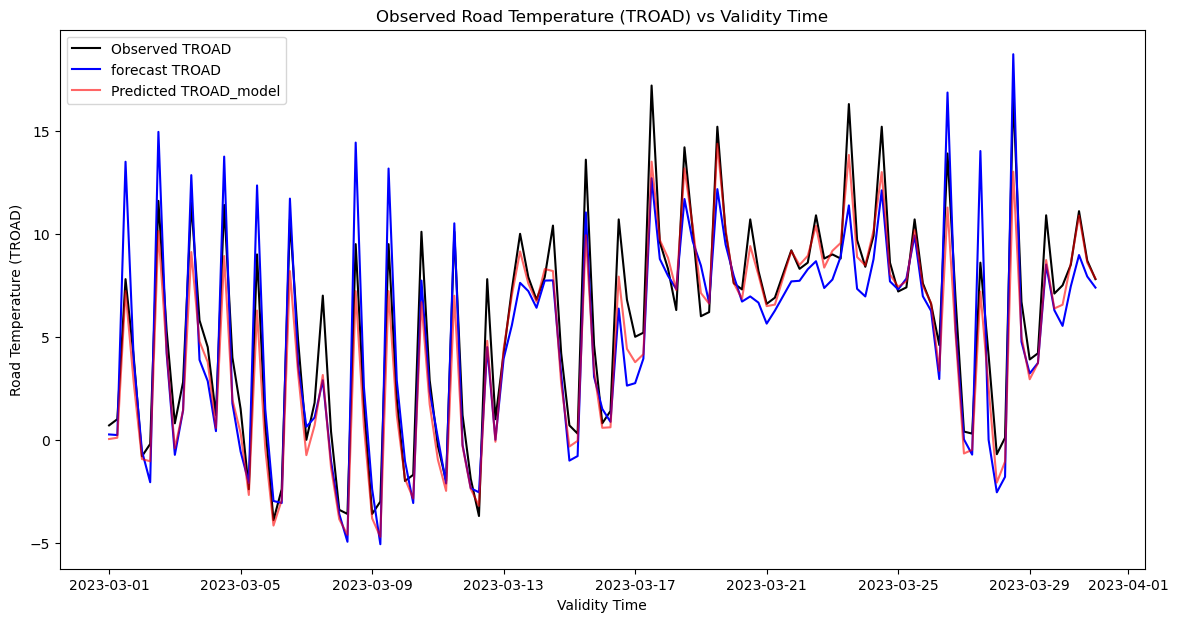

In [101]:
# Plot TROAD versus validity_time
plt.figure(figsize=(14, 7))
plt.plot(test_df['validity_time'], test_df['TROAD'], label='Observed TROAD', color='black')
plt.plot(test_df["validity_time"],test_df["forecast_temp"],label="forecast TROAD",color="blue")
plt.plot(test_df['validity_time'], test_df['forecast_temp_model'], label='Predicted TROAD_model', color='red', alpha=0.6)

plt.xlabel('Validity Time')
plt.ylabel('Road Temperature (TROAD)')
plt.title('Observed Road Temperature (TROAD) vs Validity Time')
plt.legend()
plt.show()

In [102]:
# Calculate the bias (errors)
original_bias = test_df['forecast_temp'] - test_df["TROAD"]
model_bias = test_df["forecast_temp_model"] - test_df["TROAD"]

In [103]:
#merged_df['TROAD_model'] = model.predict(X)


In [104]:
# Plot TROAD and TROAD_model against validity_time
#plt.figure(figsize=(14, 7))
#plt.plot(merged_df['validity_time'], merged_df['TROAD'], label='Observed TROAD', color='blue', alpha=0.6)
#plt.plot(merged_df['validity_time'], merged_df['TROAD_model'], label='Predicted TROAD_model', color='red', alpha=0.6)

#plt.xlabel('Validity Time')
#plt.ylabel('Road Temperature (TROAD)')
#plt.title('Observed vs Predicted Road Temperature')
#plt.legend()
#plt.show()

/tmp/ipykernel_159444/1218358151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['orig_bias'] = test_df["forecast_temp"] - test_df["TROAD"]
/tmp/ipykernel_159444/1218358151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["new_bias"] = test_df["forecast_temp_model"] - test_df["TROAD"]


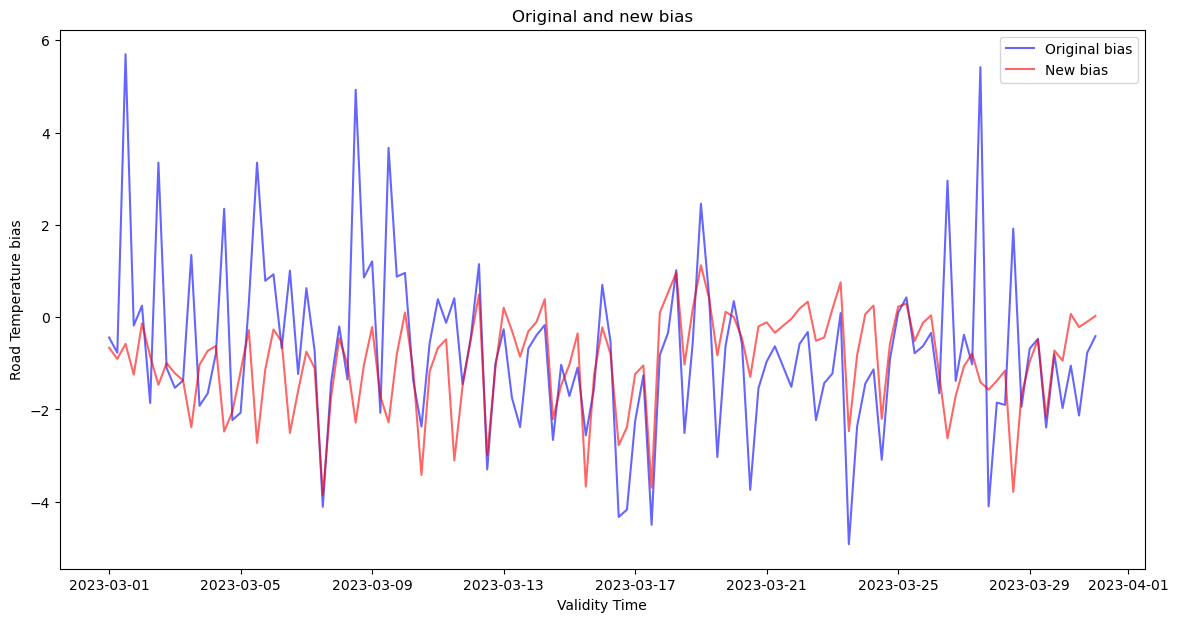

In [105]:
test_df['orig_bias'] = test_df["forecast_temp"] - test_df["TROAD"]
test_df["new_bias"] = test_df["forecast_temp_model"] - test_df["TROAD"]

# Plot TROAD and TROAD_model against validity_time
plt.figure(figsize=(14, 7))
plt.plot(test_df['validity_time'], test_df['orig_bias'], label='Original bias', color='blue', alpha=0.6)
plt.plot(test_df['validity_time'], test_df['new_bias'], label='New bias', color='red', alpha=0.6)

plt.xlabel('Validity Time')
plt.ylabel('Road Temperature bias')
plt.title('Original and new bias')
plt.legend()
plt.show()

In [106]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Group by lead_hrs and calculate RMSE for each group
rmse_results = []

for lead_hr, group in test_df.groupby('lead_hrs'):
    rmse_original = calculate_rmse(group['TROAD'], group['forecast_temp'])
    rmse_model = calculate_rmse(group['TROAD'], group['forecast_temp_model'])
    rmse_results.append((lead_hr, rmse_original, rmse_model))

# Convert results to a DataFrame for better readability
rmse_df = pd.DataFrame(rmse_results, columns=['lead_hrs', 'RMSE_Original', 'RMSE_Model'])



print(rmse_df)


# Function to calculate bias (mean error)
def calculate_bias(y_true, y_pred):
    return np.mean(y_true - y_pred)

# Group by lead_hrs and calculate bias for each group
bias_results = []

for lead_hr, group in test_df.groupby('lead_hrs'):
    bias_original = calculate_bias(group['TROAD'], group['forecast_temp'])
    bias_model = calculate_bias(group['TROAD'], group['forecast_temp_model'])
    bias_results.append((lead_hr, bias_original, bias_model))

# Convert results to a DataFrame for better readability
bias_df = pd.DataFrame(bias_results, columns=['lead_hrs', 'Bias_Original', 'Bias_Model'])

print(bias_df)

   lead_hrs  RMSE_Original  RMSE_Model
0         6       1.084389    0.800972
1        12       3.289541    2.398739
2        18       1.621778    1.164852
3        24       1.159204    0.686516
   lead_hrs  Bias_Original  Bias_Model
0         6       0.706667    0.433419
1        12       0.503793    2.149161
2        18       1.179000    0.945701
3        24       0.423871    0.357332


### Testing a random forest model below

In [107]:
# Create a Random Forest model
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict the road temperature for the test data
y_pred_test = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 3.891683095583329
R-squared: 0.8509596436747993


In [108]:
test_df['forecast_temp_model'] = rf_model.predict(test_df[['TROAD', 'S10m', 'D10m', 'CCtot',"T2m"]])


/tmp/ipykernel_159444/4000954555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forecast_temp_model'] = rf_model.predict(test_df[['TROAD', 'S10m', 'D10m', 'CCtot',"T2m"]])


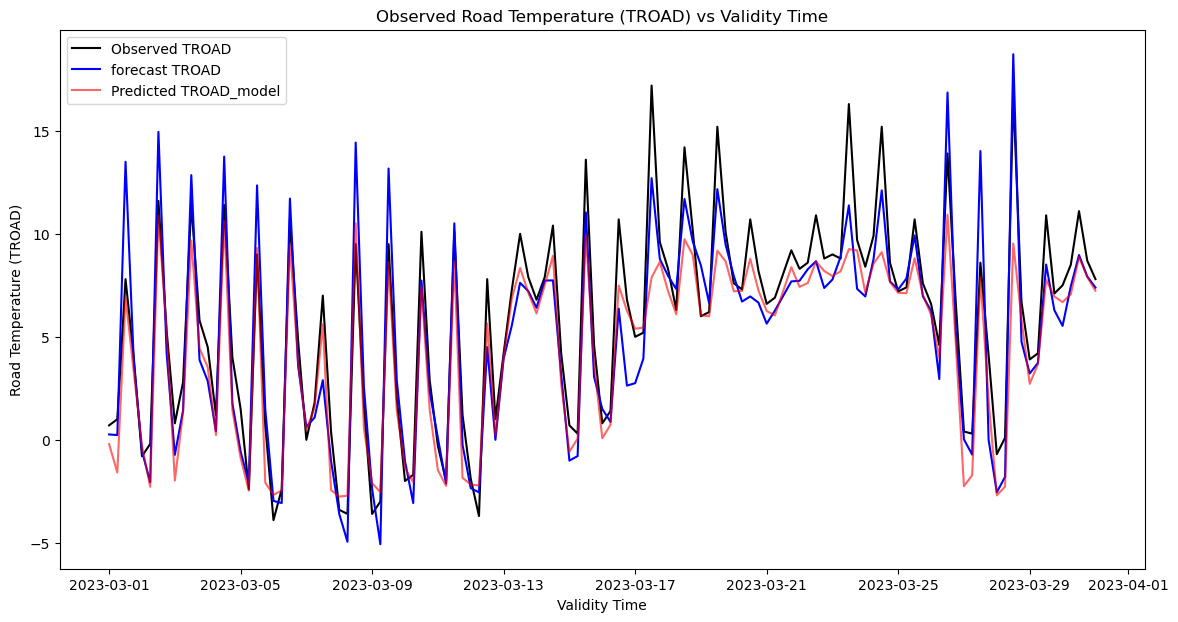

In [109]:
# Plot TROAD versus validity_time
plt.figure(figsize=(14, 7))
plt.plot(test_df['validity_time'], test_df['TROAD'], label='Observed TROAD', color='black')
plt.plot(test_df["validity_time"],test_df["forecast_temp"],label="forecast TROAD",color="blue")
plt.plot(test_df['validity_time'], test_df['forecast_temp_model'], label='Predicted TROAD_model', color='red', alpha=0.6)

plt.xlabel('Validity Time')
plt.ylabel('Road Temperature (TROAD)')
plt.title('Observed Road Temperature (TROAD) vs Validity Time')
plt.legend()
plt.show()

/tmp/ipykernel_159444/1218358151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['orig_bias'] = test_df["forecast_temp"] - test_df["TROAD"]
/tmp/ipykernel_159444/1218358151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["new_bias"] = test_df["forecast_temp_model"] - test_df["TROAD"]


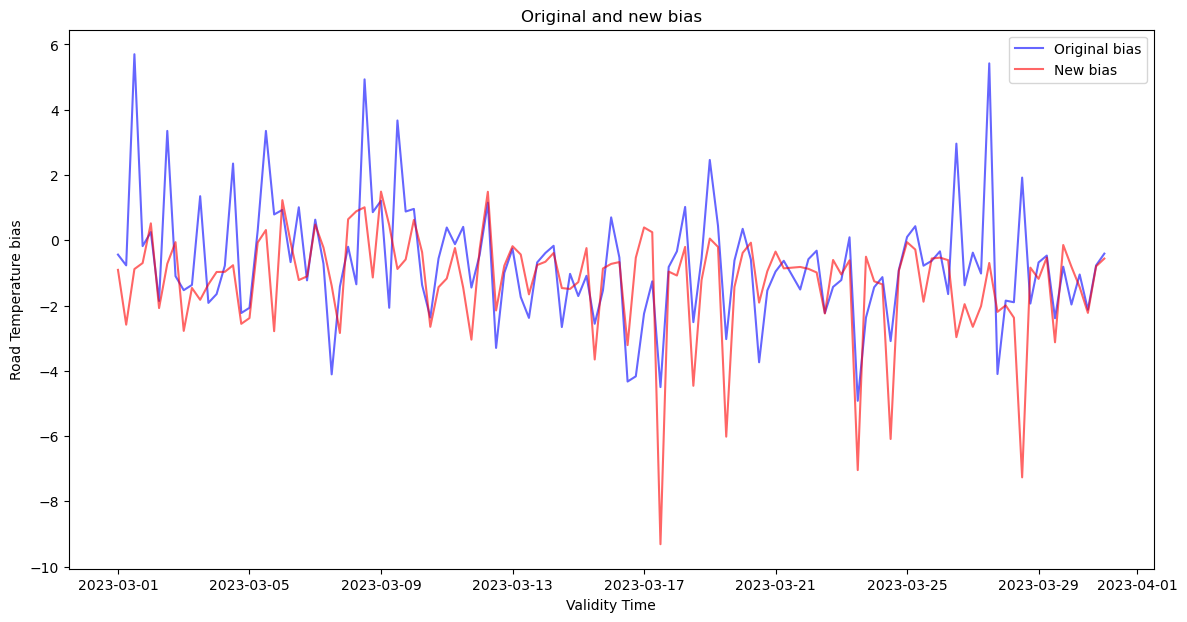

In [110]:
test_df['orig_bias'] = test_df["forecast_temp"] - test_df["TROAD"]
test_df["new_bias"] = test_df["forecast_temp_model"] - test_df["TROAD"]

# Plot TROAD and TROAD_model against validity_time
plt.figure(figsize=(14, 7))
plt.plot(test_df['validity_time'], test_df['orig_bias'], label='Original bias', color='blue', alpha=0.6)
plt.plot(test_df['validity_time'], test_df['new_bias'], label='New bias', color='red', alpha=0.6)

plt.xlabel('Validity Time')
plt.ylabel('Road Temperature bias')
plt.title('Original and new bias')
plt.legend()
plt.show()

In [111]:
### rubbish below for the moment...

In [112]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Group by lead_hrs and calculate RMSE for each group
rmse_results = []

for lead_hr, group in test_df.groupby('lead_hrs'):
    rmse_original = calculate_rmse(group['TROAD'], group['forecast_temp'])
    rmse_model = calculate_rmse(group['TROAD'], group['forecast_temp_model'])
    rmse_results.append((lead_hr, rmse_original, rmse_model))

# Convert results to a DataFrame for better readability
rmse_df = pd.DataFrame(rmse_results, columns=['lead_hrs', 'RMSE_Original', 'RMSE_Model'])



print(rmse_df)


# Function to calculate bias (mean error)
def calculate_bias(y_true, y_pred):
    return np.mean(y_true - y_pred)

# Group by lead_hrs and calculate bias for each group
bias_results = []

for lead_hr, group in test_df.groupby('lead_hrs'):
    bias_original = calculate_bias(group['TROAD'], group['forecast_temp'])
    bias_model = calculate_bias(group['TROAD'], group['forecast_temp_model'])
    bias_results.append((lead_hr, bias_original, bias_model))

# Convert results to a DataFrame for better readability
bias_df = pd.DataFrame(bias_results, columns=['lead_hrs', 'Bias_Original', 'Bias_Model'])

print(bias_df)

   lead_hrs  RMSE_Original  RMSE_Model
0         6       1.084389    1.079835
1        12       3.289541    3.579591
2        18       1.621778    1.429006
3        24       1.159204    1.178216
   lead_hrs  Bias_Original  Bias_Model
0         6       0.706667    0.608797
1        12       0.503793    2.685331
2        18       1.179000    1.199307
3        24       0.423871    0.603819


In [113]:
# Calculate the differences between observed and predicted values
diff_original = test_df['forecast_temp'] - test_df['TROAD']
diff_model = test_df['forecast_temp_model'] - test_df['TROAD']

# Square the differences
squared_diff_original = diff_original ** 2
squared_diff_model = diff_model ** 2

# Compute the mean of the squared differences
mean_squared_diff_original = np.mean(squared_diff_original)
mean_squared_diff_model = np.mean(squared_diff_model)

# Take the square root of the mean squared differences to get RMSE
rmse_original = np.sqrt(mean_squared_diff_original)
rmse_model = np.sqrt(mean_squared_diff_model)

In [ ]:
### rubbish below...

In [ ]:


# Assuming your dataframe is named df
# Calculate the forecast error
df['forecast_error'] = df['observed_road_temp'] - df['forecasted_road_temp']

# Prepare the feature matrix X and the target vector y
X = df[['time_of_day', 'observed_air_temp', 'observed_wind_speed', 'observed_wind_direction']]
y = df['forecast_error']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict the forecast error on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# If you want to see the coefficients of the model
print("Model Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef}")
